# Getting started
This notebook demonstrates the basic functionality of the HPS API and shows how to start a training session and run evaluations. 

In [1]:
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '../..'))

In [2]:
import pandas as pd
import numpy as np
from hps_api_client.apiproxy import ApiProxy

## Create client
 - The ApiProxy client facilitates access to the api functions and provides classes that wrap the json objects which are exchanged with the server
 - The proxy is preconfigured to point at the api

In [3]:
client = ApiProxy(uri = "http://leviathan:5400/api/v1/")
# help(ApiProxy)

## List available projects
 - Projects are a means to organize trainig sessions
 - All projects created by any user will be listed

In [4]:
projects = client.get_projects()
projects

""


## List hydrosystems
Hydro systems are pre-configured for our customers and cannot be added through the API.
 

In [5]:
hydro_systems = client.get_hydro_systems()
hydro_system = hydro_systems[-2]
hydro_systems

,description,name,uid
0,Representasjonen av hydrosystemet small,small,e98aff01-526b-44d0-a950-bc17aa2382ad
1,Representasjonen av hydrosystemet medium,medium,ed4329fe-009a-425b-ad1d-a8c8778b5e82
2,Representasjonen av hydrosystemet large,large,a106ab98-a324-43cf-9641-3214ac2d7656


## Create a new project
For this tutorial we will create a new project for the hydro system medium

In [6]:
project_name = "Demo III"
selected_hydro_system = hydro_system
new_project = client.create_project(project_name, selected_hydro_system)
new_project

,name,uid,hydroSystem.description,hydroSystem.name,hydroSystem.uid
0,Demo III,27b0cfed-d516-479b-bb2b-ce0be2c5acdc,Representasjonen av hydrosystemet medium,medium,ed4329fe-009a-425b-ad1d-a8c8778b5e82


## Get forecasts
We are going to pick a forecast to train our agent on. First we list available forecasts.

In [7]:
forecasts = client.get_forecasts(selected_hydro_system)
forecasts

,name,uid
0,My example forecast,ccf1d753-5e22-4d19-a169-d82a85a035a4


We will use the most recent forecast 

In [8]:
selected_forecast = forecasts[-1]
selected_forecast

,name,uid
0,My example forecast,ccf1d753-5e22-4d19-a169-d82a85a035a4


## Get reservoirs for hydro system

In [9]:
reservoirs = client.get_reservoirs(selected_hydro_system)
reservoirs

,minVolume,maxVolume,name,uid
0,0.0,40.5,res1,14cdfd13-744d-4331-ad41-9e50b790fb3b
1,0.0,515.6,res2,ecc44503-980d-4efd-9f86-5bf13b65236e
2,0.0,22.3,res3,ca4c24ef-4439-4fd3-8d90-ad284535c350


## Start training
When starting a training run, a settings object has to be provided. A template for these settings can be retrieved from the API.

In [10]:
settings = client.get_settings_template(new_project)
print(settings.to_json())

{
    "comment": null,
    "trainEpisodes": 10000,
    "endStateIncentive": "MeanEnergyPrice",
    "noise": "Off",
    "previousProjectRunUid": null,
    "previousQValueProjectRunUid": null,
    "discountRate": 0.04,
    "startVolumes": {
        "res1": 0.0,
        "res2": 0.0,
        "res3": 0.0
    },
    "stepsInEpisode": 104,
    "stepResolution": "Week",
    "stepFrequency": 1,
    "randomizeStartVolume": true,
    "rewardScaleFactor": 10.0,
    "forecastClusters": 7,
    "priceOfSpillage": 1.0,
    "endEnergyPrice": 0.0,
    "evaluationEpisodes": 5,
    "evaluationInterval": 30,
    "agentAlgorithm": "SAC"
}


Before starting the run, we will modify some of the settings

In [11]:
# It is important to give the run a description, so we can identify it later
settings.comment = "demo run"

# We are setting all initial reservoir volumes to half capacity
settings.startVolumes = {}
for r in reservoirs:
    settings.startVolumes[r.name] = r.maxVolume / 2

We can now start the trainig session in the context of our new project and using the forcast and settings as specified above

In [12]:
run = client.run(new_project, selected_forecast, settings)
run

b'"There is a problem accessing the backend service. Please contact support."'


HTTPError: 500 Server Error: Internal Server Error for url: http://leviathan:5400/api/v1/projects/27b0cfed-d516-479b-bb2b-ce0be2c5acdc/run?forecastUid=ccf1d753-5e22-4d19-a169-d82a85a035a4

As we can see above, initially the run has neither start- nor endTime specified. As soon as the backend starts the training process, the startTime will be set. When the training process has completed the endTime will also be specified.
We can now call get_runs for our project to the status of our run.

In [15]:
runs = client.get_runs(new_project)
runs

,startTime,endTime,name,uid,settings.comment,settings.trainEpisodes,settings.endStateIncentive,settings.noise,settings.previousProjectRunUid,settings.previousQValueProjectRunUid,...,settings.randomizeStartVolume,settings.rewardScaleFactor,settings.forecastClusters,settings.priceOfSpillage,settings.endEnergyPrice,settings.evaluationEpisodes,settings.evaluationInterval,settings.agentAlgorithm,forecast.name,forecast.uid
0,2023-01-09T09:11:49.494156+01:00,None,demo run,a0b4a2d1-d481-4610-9c8d-e35d0b7b0147,demo run,10000,MeanEnergyPrice,Off,None,None,...,True,10.0,7,1.0,0.0,5,30,SAC,My example forecast,a4c415fa-979e-4797-b00b-1330af83add3


During training it can be useful to monitor the progress. The show_progress method will display the maximum reward achieved  over time, and can be a good way to identify convergence.

In [ ]:
client.

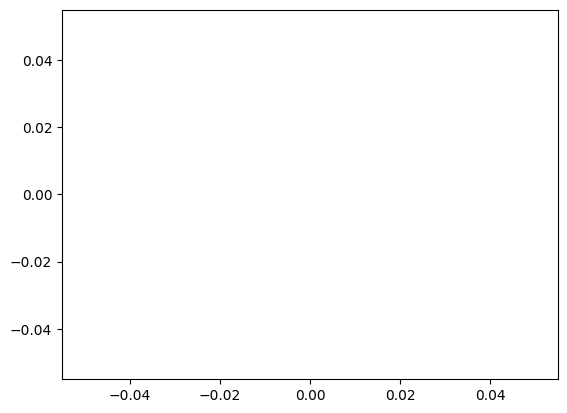

In [20]:
client.show_progress(run)

At any time during or after training we can retrieve the best solution produced by the agent.

In [21]:
client.plot_solution(run)

A training session can be terminated before it has run to completion.

In [ ]:
client.terminate_run(run)

## Evaluation
During training we normally evaluate only a subset of the forecast scenarios to determine convergence of the solution. After or during training we can perform more detailed evaluations.

In [28]:
settings.comment = "demo evaluation"
# settings.evaluationEpisodes = 8
evaluation = client.evaluate(run, selected_forecast, settings)
evaluation

,startTime,endTime,name,uid,settings.comment,settings.trainEpisodes,settings.endStateIncentive,settings.noise,settings.previousProjectRunUid,settings.previousQValueProjectRunUid,...,settings.randomizeStartVolume,settings.rewardScaleFactor,settings.forecastClusters,settings.priceOfSpillage,settings.endEnergyPrice,settings.evaluationEpisodes,settings.evaluationInterval,settings.agentAlgorithm,forecast.name,forecast.uid
0,None,None,demo evaluation,b90666d9-375d-484c-bb79-a8f4355e718f,demo evaluation,10000,MeanEnergyPrice,Off,None,None,...,True,10.0,7,1.0,0.0,5,30,SAC,My example forecast,a4c415fa-979e-4797-b00b-1330af83add3


As with a trainig session, the evaluation is completed when the endTime is set.

In [27]:
client.get_evaluations(new_project)

,startTime,endTime,name,uid,settings.comment,settings.trainEpisodes,settings.endStateIncentive,settings.noise,settings.previousProjectRunUid,settings.previousQValueProjectRunUid,...,settings.randomizeStartVolume,settings.rewardScaleFactor,settings.forecastClusters,settings.priceOfSpillage,settings.endEnergyPrice,settings.evaluationEpisodes,settings.evaluationInterval,settings.agentAlgorithm,forecast.name,forecast.uid
0,2023-01-09T09:23:56.567857+01:00,None,demo evaluation,208f7dbe-2b50-4621-84f9-ced01fb0ee30,demo evaluation,10000,MeanEnergyPrice,Off,None,None,...,True,10.0,7,1.0,0.0,5,30,SAC,My example forecast,a4c415fa-979e-4797-b00b-1330af83add3


We can plot the results of the evaluation

In [24]:
client.plot_evaluation(evaluation)

And for further processing, we can retrieve the result data as a pandas DataFrame

In [ ]:
df = client.get_evaluation(evaluation)
df

In [ ]:
df['res2'].plot(figsize=(20,15))